<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson07_automl/lecture_note_regression_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行うこと

これまでの授業の復習として以下のことを行ってください。
1. データをダウンロードする
2. Pubchem,RDKit,MOPACなどを用いて説明変数を作成する。
3. 機械学習を用いて、テストデータの予測を行う。
4. テストデータの予測値を課題提出場所に提出してください｡

# pycaretの関数

1. データの前処理：　setup()
2. モデルの比較： compare_models()
3. 分析モデルの生成： create_model()
4. チューニング： tune_model()
5. 可視化： plot_model()
6. 評価： evaluate_model()
7. 予測： finalize_model(), predict_model()

# ライブラリーのインストール

In [50]:
!pip install rdkit
!pip install pycaret==2.2.0
!pip install pandas-profiling==3.1.0
!pip install shap
!pip install scikit-learn==0.23.2 --force-reinstall

# pandas-profilingのversionを落とさないと次のエラーが出る。
# PyCaret ImportError: Missing optional dependency 'Jinja2'
# https://qiita.com/hasegatk/items/c835ba6243efbb4e53d2
# scikit-learn==0.23.2にでないとエラーがでる部分がある。

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 69.1 MB/s 
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpool

# 0. ライブラリーのインポート

In [51]:
import warnings
# 不要な警告文非表示
warnings.filterwarnings("ignore")


In [52]:
import pandas as pd
pd.__version__ # 1.3.5が表示

'1.3.5'

In [53]:
import pycaret
print(pycaret.__version__)  # 2.2.0が表示

2.2.0


In [54]:
import sklearn
print(sklearn.__version__) # 0.23.2が表示

0.23.2


In [55]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# 1. データのセットアップ

In [56]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2022-10-23 04:25:06--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat.1’

data_set.dat.1      100%[===================>]  51.67K   181KB/s    in 0.3s    

2022-10-23 04:25:06 (181 KB/s) - ‘data_set.dat.1’ saved [52906/52906]



In [57]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
import numpy as np

# データの呼び出しなど
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"]) 
PandasTools.AddMoleculeColumnToFrame(df, "smiles")
df = df.dropna(subset=['ROMol'], axis=0)
df = df.reset_index()

# fingerprintの作成
fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
        
    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
df_fp = pd.DataFrame(fingerprints)

# dfをあわせて表示
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)

index   smiles      CAS  logS  \
0      0  O=C(C)N  60-35-5  1.58   

                                               ROMol  0  1  2  3  4  ...  \
0  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   

   2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0     0  

[1 rows x 2053 columns]
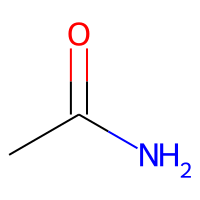

In [58]:
df_comb.head(1)

In [141]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_comb, test_size = 0.1, random_state = 10)

index    smiles       CAS  logS  \
0      0   O=C(C)N   60-35-5  1.58   
1      1       NNC   60-34-4  1.34   
2      2   O=C(C)O   64-19-7  1.22   
3      3   N1CCCC1  123-75-1  1.15   
4      4  O=C(N)NO  127-07-1  1.12   

                                               ROMol  0  1  2  3  4  ...  \
0  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
2  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
3  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
4  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   

   2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0     0  

[5 rows x 2053 columns]
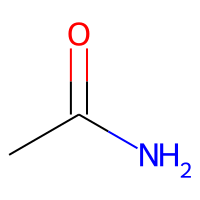
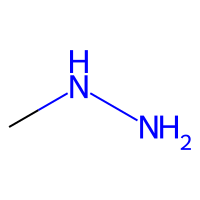
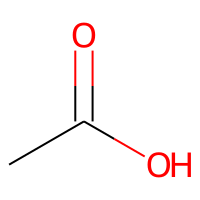
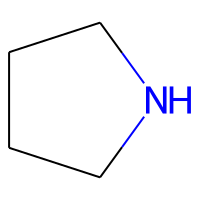
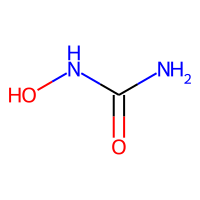

In [65]:
df_train.sort_index().head()

index            smiles        CAS  logS  \
7       7  [nH0]1cccc[nH0]1   289-80-5  1.10   
11     11          N1CCNCC1   110-85-0  1.07   
31     31            O=CC=C   107-02-8  0.57   
35     35             COCOC   109-87-5  0.48   
43     43           O=CC=CC  4170-30-3  0.32   

                                                ROMol  0  1  2  3  4  ...  \
7   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
11  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
31  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
35  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
43  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   

    2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  
7      0     0     0     0     0     0     0     0     0     0  
11     0     0     0     0     0     0     0     0     0     0  
31     0     0     0     0     0     0     0     0     0     0  
35     0     0     0     0     0     0     0     0     0     0  
43     0     0     0     0     0     0     0     0     0     0  

[5 rows x 2053 columns]
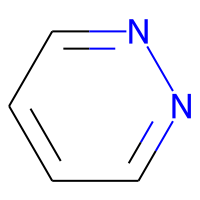
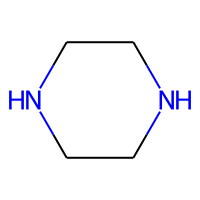
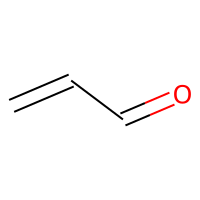
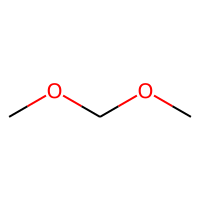
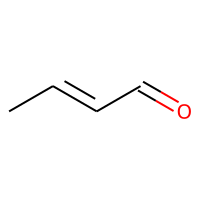

In [64]:
df_test.sort_index().head()

In [69]:
from pycaret.regression import *
exp1 = setup(df_train, target = 'logS', ignore_features= ['index', 'smiles', 'CAS', 'ROMol'], silent=True, fold_shuffle=True, session_id=123, test_data=df_test)

#今回は、テストとトレーニングデータを事前に用意しているのでtest_dataにdf_testにしています。
# train_sizeを設定して、ここで設定することもできます。

# 参考の解説記事
# https://qiita.com/Asagumo63/items/99357d4b472a9219040e
# もとの記事
# https://pycaret.gitbook.io/docs/get-started/quickstart?q=setup#regression

Description             Value
0                               session_id               123
1                                   Target              logS
2                            Original Data      (1160, 2053)
3                           Missing Values             False
4                         Numeric Features                 0
5                     Categorical Features              2048
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set      (1160, 1947)
10                    Transformed Test Set       (129, 1947)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number                10
15                                CPU Jobs                -1
16                                 Use GPU             False
17                          Log Experiment             False
18                         Experiment Name  reg-default-name
19                                     USI              db37
20                         Imputation Type            simple
21          Iterative Imputation Iteration              None
22                         Numeric Imputer              mean
23      Iterative Imputation Numeric Model              None
24                     Categorical Imputer          constant
25  Iterative Imputation Categorical Model              None
26           Unknown Categoricals Handling    least_frequent
27                               Normalize             False
28                        Normalize Method              None
29                          Transformation             False
30                   Transformation Method              None
31                                     PCA             False
32                              PCA Method              None
33                          PCA Components              None
34                     Ignore Low Variance             False
35                     Combine Rare Levels             False
36                    Rare Level Threshold              None
37                         Numeric Binning             False
38                         Remove Outliers             False
39                      Outliers Threshold              None
40                Remove Multicollinearity             False
41             Multicollinearity Threshold              None
42                              Clustering             False
43                    Clustering Iteration              None
44                     Polynomial Features             False
45                       Polynomial Degree              None
46                    Trignometry Features             False
47                    Polynomial Threshold              None
48                          Group Features             False
49                       Feature Selection             False
50            Features Selection Threshold              None
51                     Feature Interaction             False
52                           Feature Ratio             False
53                   Interaction Threshold              None
54                        Transform Target             False
55                 Transform Target Method           box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['index', 'smiles', 'CAS',
                                                       'ROMol'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='logS',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),

## 学習データの分割や説明変数について確認

In [70]:
y_test = get_config('y_test')　# 分割後のテスト用目的変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=y_test)
INFO:logs:Global variable: y_test returned as 1256   -6.02
142    -0.80
689    -4.19
989    -1.45
124    -0.70
        ... 
454    -2.56
225    -1.40
375    -2.16
411    -2.35
861    -7.92
Name: logS, Length: 129, dtype: float32
INFO:logs:get_config() succesfully completed......................................


In [71]:
X_test = get_config('X_test') # 分割後のテスト用説明変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_test)
INFO:logs:Global variable: X_test returned as       0_1  1_0  2_1  3_1  4_0  5_0  6_0  7_0  8_0  9_1  ...  2037_1  2038_0  \
1256  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
142   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
689   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
989   0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
124   0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
454   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
225   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
375   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
411   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
861   0.0  

In [72]:
y_train = get_config('y_train')　# 分割後の学習用目的変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=y_train)
INFO:logs:Global variable: y_train returned as 373    -2.15
555    -3.18
1152   -3.46
1238   -4.88
764    -4.95
        ... 
733    -4.57
1180   -3.84
1147   -3.38
527    -3.02
1149   -3.39
Name: logS, Length: 1160, dtype: float32
INFO:logs:get_config() succesfully completed......................................


In [73]:
X_train = get_config('X_train') # 分割後の学習用説明変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as       0_1  1_0  2_1  3_1  4_0  5_0  6_0  7_0  8_0  9_1  ...  2037_1  2038_0  \
373   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
555   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  ...     0.0     1.0   
1152  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
1238  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
764   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
733   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
1180  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
1147  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
527   0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
1149  0.0

# pandas_profiling　重いです。

In [ ]:
# import pandas_profiling
# profile = df_comb.profile_report()

In [ ]:
# profile

In [ ]:
# profile.to_file("myoutputfile.html")

# このファイルのままだと、一時保存場所なので、時間が経つと消えます。
# ファイルの保存場所をdriveの中にすれば、google driveに保存される。

# 2. モデルの比較： compare_models()

In [74]:
best = compare_models(fold=10) # デフォルトは、foldが10。交差検証の数です。小さくすると短い時間で終わりますが、データ検証としては不十分なときも。

Model           MAE           MSE  \
catboost               CatBoost Regressor  8.097000e-01  1.186600e+00   
xgboost         Extreme Gradient Boosting  8.300000e-01  1.241300e+00   
br                         Bayesian Ridge  8.429000e-01  1.289400e+00   
lightgbm  Light Gradient Boosting Machine  8.659000e-01  1.287900e+00   
rf                Random Forest Regressor  8.477000e-01  1.328600e+00   
gbr           Gradient Boosting Regressor  9.632000e-01  1.557900e+00   
ridge                    Ridge Regression  9.314000e-01  1.620500e+00   
par          Passive Aggressive Regressor  1.036500e+00  1.834300e+00   
knn                 K Neighbors Regressor  1.018600e+00  1.858900e+00   
et                  Extra Trees Regressor  1.043900e+00  2.051100e+00   
omp           Orthogonal Matching Pursuit  1.098600e+00  2.206300e+00   
dt                Decision Tree Regressor  1.116000e+00  2.264500e+00   
ada                    AdaBoost Regressor  1.270800e+00  2.483600e+00   
huber                     Huber Regressor  0.000000e+00  0.000000e+00   
lasso                    Lasso Regression  1.582700e+00  4.092800e+00   
en                            Elastic Net  1.582700e+00  4.092800e+00   
llar         Lasso Least Angle Regression  1.582700e+00  4.092800e+00   
lr                      Linear Regression  3.774271e+03  6.862098e+07   
lar                Least Angle Regression  9.577427e+06  1.061104e+17   

                  RMSE            R2   RMSLE          MAPE  TT (Sec)  
catboost  1.087900e+00  7.053000e-01  0.3097  1.072800e+00    65.956  
xgboost   1.112400e+00  6.928000e-01  0.3163  1.019000e+00     7.461  
br        1.134000e+00  6.812000e-01  0.3246  9.598000e-01     6.159  
lightgbm  1.133400e+00  6.801000e-01  0.3224  9.705000e-01     0.335  
rf        1.151000e+00  6.704000e-01  0.3246  1.140500e+00     7.728  
gbr       1.246800e+00  6.138000e-01  0.3423  1.373600e+00     2.272  
ridge     1.271600e+00  5.978000e-01  0.3571  1.116400e+00     0.111  
par       1.331800e+00  5.353000e-01  0.3873  9.261000e-01     0.421  
knn       1.361500e+00  5.345000e-01  0.3893  1.132900e+00     0.589  
et        1.423700e+00  4.900000e-01  0.3986  1.394500e+00    10.835  
omp       1.482100e+00  4.462000e-01  0.4177  1.358400e+00     0.156  
dt        1.493600e+00  4.388000e-01  0.4157  1.571000e+00     0.177  
ada       1.573600e+00  3.873000e-01  0.4334  2.265900e+00     2.765  
huber     0.000000e+00  0.000000e+00  0.0000  0.000000e+00     4.353  
lasso     2.019200e+00 -7.100000e-03  0.5246  2.882500e+00     0.062  
en        2.019200e+00 -7.100000e-03  0.5246  2.882500e+00     0.060  
llar      2.019200e+00 -7.100000e-03  0.5246  2.882500e+00     0.063  
lr        5.934415e+03 -1.825192e+07  5.7054  6.033228e+03     0.822  
lar       1.030420e+08 -2.395068e+16  2.2717  1.805605e+07     0.465

INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 1
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7fb2d77c0910>
INFO:logs:compare_models() succesfully completed......................................


# 3. 分析モデルの生成： create_model()

In [110]:
#どんなモデルが入っているかを確認できる。
models()

INFO:logs:gpu_param set to False


Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp            pycaret.internal.tunable.TunableMLPRegressor  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True

In [77]:
# compare_modelsでベストでなくても、名前を設定すると、そのモデルを作成してくれます。予めモデルが決まっているときも便利です。
lr = create_model('xgboost')
# models()で表示させたID名を指定します。

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.8626  1.4537  1.2057  0.6232  0.3337  0.6514
1     0.7957  1.1409  1.0681  0.6960  0.3149  1.8031
2     0.9005  1.4792  1.2162  0.6908  0.3382  1.7210
3     0.8498  1.3019  1.1410  0.7414  0.3085  0.7968
4     0.8231  1.0686  1.0337  0.6889  0.3181  1.0797
5     0.7998  1.2509  1.1184  0.6758  0.3101  0.9612
6     0.8247  1.2494  1.1178  0.7180  0.3288  1.3843
7     0.7706  1.0432  1.0214  0.7113  0.3040  0.7649
8     0.8723  1.2480  1.1172  0.6802  0.3108  0.4120
9     0.8006  1.1768  1.0848  0.7020  0.2961  0.6153
Mean  0.8300  1.2413  1.1124  0.6928  0.3163  1.0190
SD    0.0384  0.1374  0.0613  0.0296  0.0128  0.4504

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 2
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0, ...)
INFO:logs:create_model() succesfully completed......................................


# 4. チューニング： tune_model()

In [78]:
# モデルをチューニングしていきます。 compare_modelsで得られたbestで指定するか、create_modelで作成したlrを指定します。
tuned_lr = tune_model(lr, optimize = "R2", fold = 10, n_iter = 10) 
# デフォルトは、optimize = "R2", foldが10, n_iterのデフォルトは10。

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.8193  1.2561  1.1207  0.6744  0.3243  0.6449
1     0.8103  1.1328  1.0644  0.6981  0.3050  1.9044
2     0.7480  1.1046  1.0510  0.7691  0.3142  1.4556
3     0.7817  1.1553  1.0749  0.7705  0.2939  0.8967
4     0.7979  1.0772  1.0379  0.6864  0.3166  1.0141
5     0.7569  1.0861  1.0422  0.7185  0.2648  0.8756
6     0.8276  1.1861  1.0891  0.7323  0.3362  2.5028
7     0.8201  1.1930  1.0922  0.6698  0.3310  0.6563
8     0.8895  1.3879  1.1781  0.6444  0.3277  0.3984
9     0.8094  1.0704  1.0346  0.7289  0.3011  0.6045
Mean  0.8061  1.1649  1.0785  0.7093  0.3115  1.0953
SD    0.0378  0.0932  0.0423  0.0400  0.0202  0.6310

INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 3
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...)
INFO:logs:tune_model() succesfully completed......................................


In [108]:
print("tuning前")
print(lr)
print("tuning後")
print(tuned_lr)

tuning前
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0, ...)
tuning後
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwis

# 5. 可視化： plot_model()

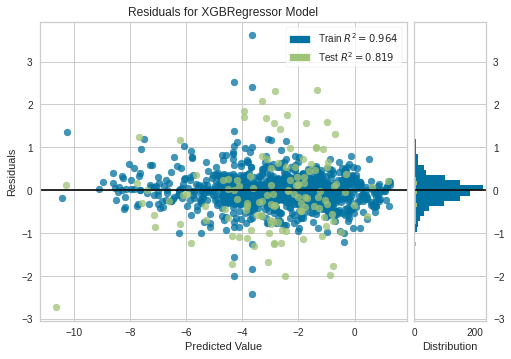

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [119]:
#  残差（residual）とは、観測された値と予測値との差の算出
plot_model(tuned_lr, plot='residuals')

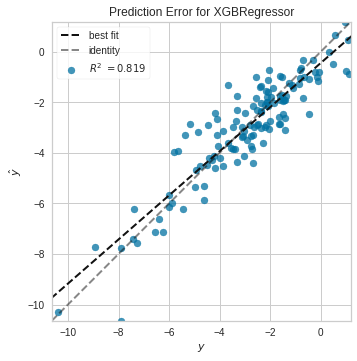

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [80]:
# 誤差プロット
plot_model(tuned_lr, plot="error")

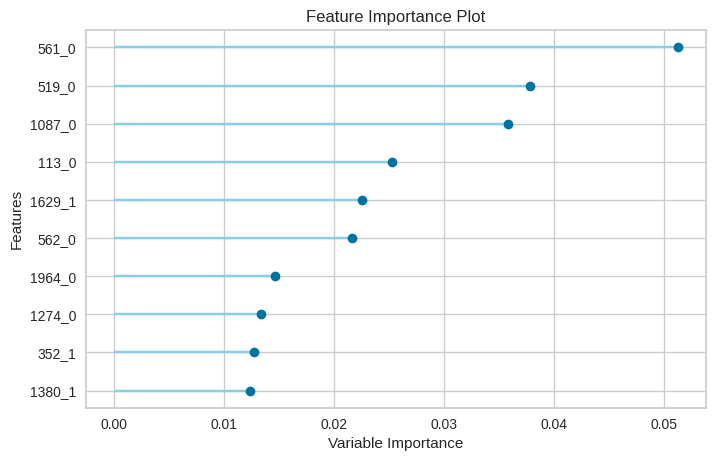

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [125]:
# 特徴量重要度 (表示できるものとできないものがある)
plot_model(tuned_lr, plot="feature")

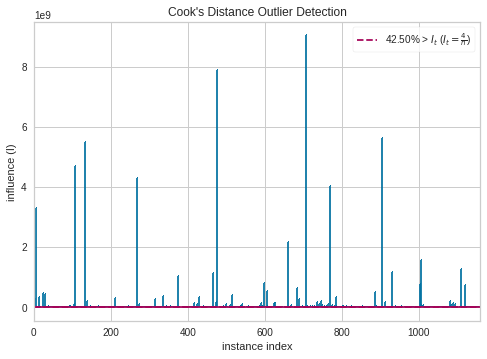

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [124]:
# Cook の距離(Cook’s distance)の算出
plot_model(tuned_lr, plot='cooks')

# 6. 評価： evaluate_model()

In [ ]:
# plot_model()で得られるものの他、色々なものを一度に出力してくれる。
evaluate_model(tuned_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=<catboost.core.CatBoostRegressor object at 0x7fb2d8153c90>, fold=None, fit_kwargs=None, feature_name=None, groups=None)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## shapを用いた解析

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), plot=summary, feature=None, kwargs={'plot_type': 'bar'}, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling 

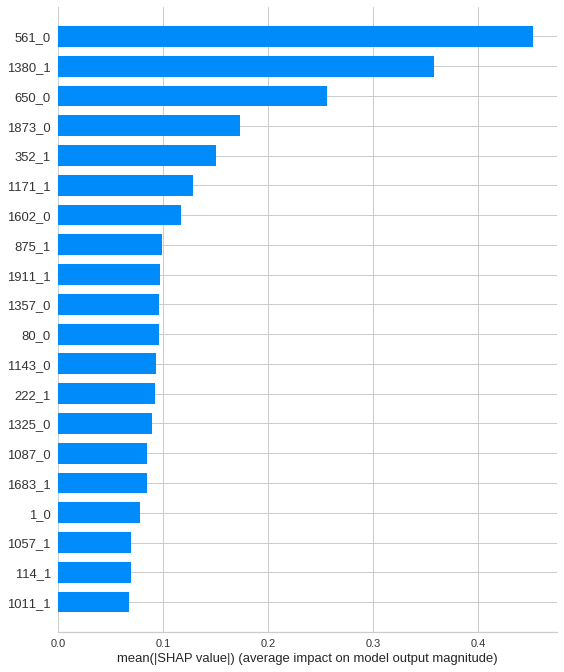

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [101]:
interpret_model(tuned_lr, plot_type="bar")

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), plot=summary, feature=None, kwargs={}, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


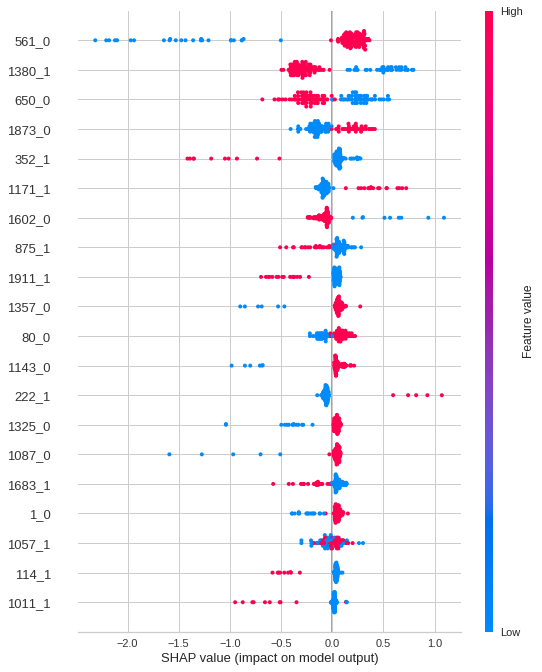

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [83]:
# モデルの解釈はSHAPを用いても行なえます。
# グラフの見方や、モデルの解釈方法については、SHAPのgitを確認ください。
interpret_model(tuned_lr)

# 7. 予測： finalize_model(), predict_model()

In [133]:
# トレーニングデータを全て使って訓連することができる。
final_lr = finalize_model(tuned_lr)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,


In [131]:
test_predictions = predict_model(final_lr)
test_predictions

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), probability_threshold=None, encoded_labels=True, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Extreme Gradient Boosting  0.6836  0.8095  0.8997  0.8191  0.2522  0.5638

0_1  1_0  2_1  3_1  4_0  5_0  6_0  7_0  8_0  9_1  ...  2039_1  2040_0  \
0    0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
1    0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
2    0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
3    0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
4    0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
124  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
125  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
126  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
127  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   
128  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  ...     0.0     1.0   

     2043_0  2043_1  2044_0  2045_1  2046_1  2047_1  logS     Label  
0       1.0     0.0     1.0     0.0     0.0     0.0 -6.02 -6.136613  
1       1.0     0.0     1.0     0.0     0.0     0.0 -0.80 -0.649746  
2       1.0     0.0     1.0     0.0     0.0     0.0 -4.19 -2.424021  
3       1.0     0.0     1.0     0.0     0.0     0.0 -1.45 -1.921321  
4       1.0     0.0     1.0     0.0     0.0     0.0 -0.70 -0.314995  
..      ...     ...     ...     ...     ...     ...   ...       ...  
124     1.0     0.0     1.0     0.0     0.0     0.0 -2.56 -1.837299  
125     1.0     0.0     1.0     0.0     0.0     0.0 -1.40 -2.616035  
126     1.0     0.0     1.0     0.0     0.0     0.0 -2.16 -1.555074  
127     1.0     0.0     1.0     0.0     0.0     0.0 -2.35 -2.047754  
128     1.0     0.0     1.0     0.0     0.0     0.0 -7.92 -7.748867  

[129 rows x 1949 columns]

## predict_model

In [142]:
train_data = predict_model(final_lr, data = df_train)
test_data = predict_model(final_lr, data = df_test)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), probability_threshold=None, encoded_labels=True, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor
INFO:

index                                          smiles         CAS  logS  \
1256   1257                    c1c(Cl)cc(c(c1)Cl)c1ccccc1Cl  37680-65-2 -6.02   
142     142                                NC(OCC(C)(C)C)=O   3124-46-7 -0.80   
689     690  O=CNC(C(Cl)(Cl)Cl)N1CCN(CC1)C(C(Cl)(Cl)Cl)NC=O  26644-46-2 -4.19   
989     990                                  OC(=O)C1CCCCC1     98-89-5 -1.45   
124     124                                     CCC(C(C)C)O    565-67-3 -0.70   
...     ...                                             ...         ...   ...   
454     455                    O1C(C)=C(CCC1)C(Nc1ccccc1)=O  24691-76-7 -2.56   
225     226                               O=C(C)Nc1ccccc1Cl    533-17-5 -1.40   
375     376                           c1c2cc(O)ccc2[nH0]cc1    580-16-5 -2.16   
411     412                               CCc1c(N)c(CC)ccc1    579-66-8 -2.35   
861     862            c1c(c2c(Cl)c(Cl)c(c(c2Cl)Cl)Cl)cccc1  18259-05-7 -7.92   

                                                  ROMol  0  1  2  3  4  ...  \
1256  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
142   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
689   <img data-content="rdkit/molecule" src="data:i...  0  1  0  0  0  ...   
989   <img data-content="rdkit/molecule" src="data:i...  0  0  1  0  0  ...   
124   <img data-content="rdkit/molecule" src="data:i...  0  1  0  0  0  ...   
...                                                 ... .. .. .. .. ..  ...   
454   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
225   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
375   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
411   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
861   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   

      2039  2040  2041  2042  2043  2044  2045  2046  2047     Label  
1256     0     0     0     0     0     0     0     0     0 -6.136613  
142      0     0     0     0     0     0     0     0     0 -0.649746  
689      0     0     0     0     0     0     0     0     0 -2.424021  
989      0     0     0     0     0     0     0     0     0 -1.921321  
124      0     0     0     0     0     0     0     0     0 -0.314995  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...       ...  
454      0     0     0     0     0     0     0     0     0 -1.837299  
225      0     0     0     0     0     0     0     0     0 -2.616035  
375      0     0     0     0     0     0     0     0     0 -1.555074  
411      0     0     0     0     0     0     0     0     0 -2.047754  
861      0     0     0     0     0     0     0     0     0 -7.748867  

[129 rows x 2054 columns]
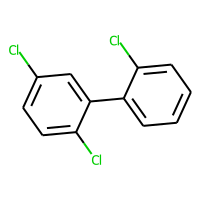
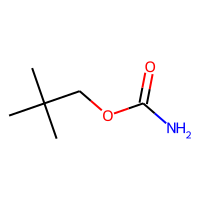
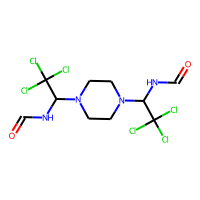
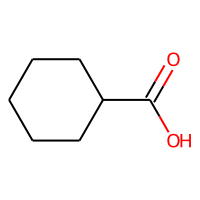
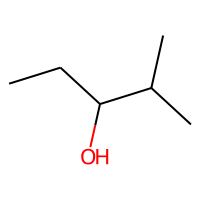
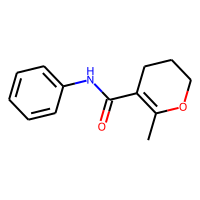
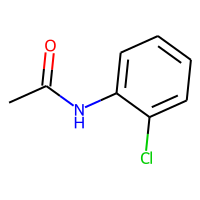
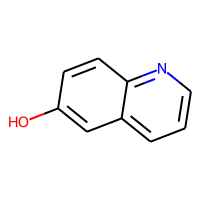
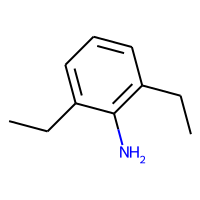
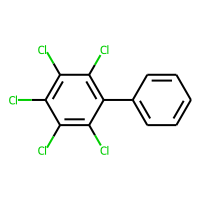

In [143]:
df_test["Label"] = test_data["Label"]
df_test

index                                       smiles         CAS  logS  \
373     374                                 C1C=CC=CC=C1    544-25-2 -2.15   
555     556             CCN(CC)CCNC(c1cc(c(cc1OC)N)Cl)=O    364-62-5 -3.18   
1152   1153                         Ic1c(I)c(c([nH]1)I)I     87-58-1 -3.46   
1238   1239            CC(N(C(=O)SCC(=C(Cl)Cl)Cl)C(C)C)C   2303-17-5 -4.88   
764     765           CC=C(C(=CC)c1ccc(cc1)O)c1ccc(cc1)O     84-17-3 -4.95   
...     ...                                          ...         ...   ...   
733     734      C1=C2CCC3C(CCC4(C)C3CCC4(C#C)O)C2CCC1=O     68-22-4 -4.57   
1180   1181                                       CCCCCC    110-54-3 -3.84   
1147   1148  CCC(C)c1cc(cc(c1O)[N+]([O-])=O)[N+]([O-])=O     88-85-7 -3.38   
527     528              Cc1c(CCCC)c(O)[nH0]c([nH0]1)NCC  23947-60-6 -3.02   
1149   1150                              CCCCCCCC(=O)OCC    106-32-1 -3.39   

                                                  ROMol  0  1  2  3  4  ...  \
373   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
555   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1152  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1238  <img data-content="rdkit/molecule" src="data:i...  0  1  0  0  0  ...   
764   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
...                                                 ... .. .. .. .. ..  ...   
733   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1180  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1147  <img data-content="rdkit/molecule" src="data:i...  0  1  0  0  0  ...   
527   <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   
1149  <img data-content="rdkit/molecule" src="data:i...  0  0  0  0  0  ...   

      2039  2040  2041  2042  2043  2044  2045  2046  2047     Label  
373      0     0     0     0     0     0     0     0     0 -2.078507  
555      0     0     0     0     0     0     0     0     0 -3.426206  
1152     0     0     0     0     0     0     0     0     0 -3.494852  
1238     0     0     0     0     0     0     0     0     0 -4.581177  
764      0     0     0     0     0     0     0     0     0 -4.690864  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...       ...  
733      0     0     0     0     0     0     0     0     0 -4.672226  
1180     0     0     0     0     0     0     0     0     0 -3.188397  
1147     0     0     0     0     0     0     0     0     0 -3.346147  
527      0     0     0     0     0     0     0     0     0 -3.323629  
1149     0     0     0     0     0     0     0     0     0 -3.308888  

[1160 rows x 2054 columns]
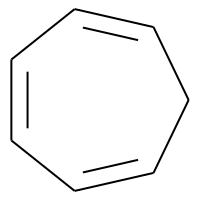
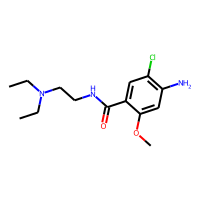
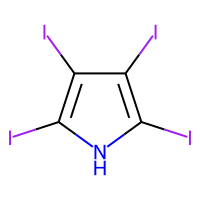
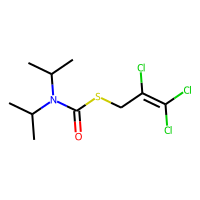
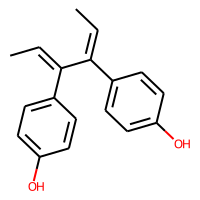
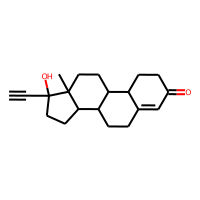
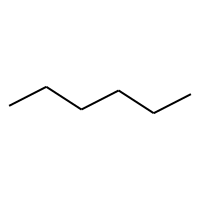
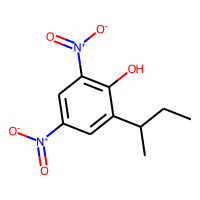
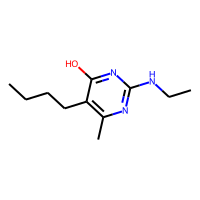
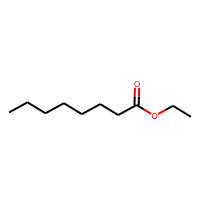

In [144]:
df_train["Label"] = train_data["Label"]
df_train

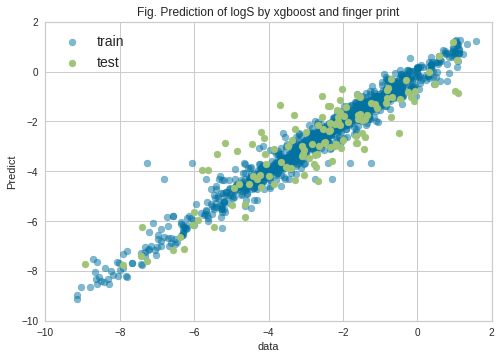

In [109]:
# グラフ作成をmatplotlibで行う
import matplotlib.pyplot as plt 

# 得られた学習結果と実験値とを比較する。
plt.figure()

# トレーニングデータのプロット
x１ = train_data["logS"]
y1 = train_data["Label"]

plt.scatter(x1, y1, alpha=0.5, label="train") # alphaを入れると薄くなる。

# テストデータのプロット
x2 = test_data["logS"]
y2 = test_data["Label"]

plt.scatter(x2, y2, label="test")

# 範囲の指定
plt.xlim(-10, 2)
plt.ylim(-10, 2)

# タイトルを入れる。
plt.title("Fig. Prediction of logS by xgboost and finger print")

# X軸とY軸にラベルを作成
plt.xlabel('data')
plt.ylabel('Predict')

# 凡例の場所を指定
plt.legend(loc="upper left", fontsize=14) 

# 表示させる
plt.show()

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_test = x2
y_pred_test = y2

# MAE（Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred_test)
print(f'mae:{mae:.4f}')
# MAPE(Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f'mape:{mape:.4f}')
# SMAPE(Symmetric Mean Absolute Percentage Error)
smape = 100/len(y_test) * np.sum(2 * np.abs(y_pred_test - y_test) / (np.abs(y_pred_test) + np.abs(y_test)))
print(f'smape:{smape:.4f}')
# mse (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_test)
print(f'mse:{mse:.4f}')
# rmse (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f'rmse: {rmse:.4f}')
# R2
score2 = r2_score(y_test, y_pred_test)
print("R2", score2)

mae:0.6836
mape:56.3764
smape:35.7230
mse:0.8095
rmse: 0.8997
R2 0.8191379960619661


8. モデルの保存

In [105]:
save_model(final_lr, 'my_best_pipeline')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), model_name=my_best_pipeline, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                    

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['index', 'smiles', 'CAS',
                                                        'ROMol'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='logS',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_num...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.323, max_bin=256,
                           

In [106]:
#load_modelで呼び出せる。
loaded_model = load_model('my_best_pipeline')
print(loaded_model)

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=my_best_pipeline, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['index', 'smiles', 'CAS',
                                                       'ROMol'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='logS',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.323, ma

# 以上です。